<a href="https://colab.research.google.com/github/DreamX55/FL-Models-Research-Paper-Codes/blob/main/Federated%2BNo_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

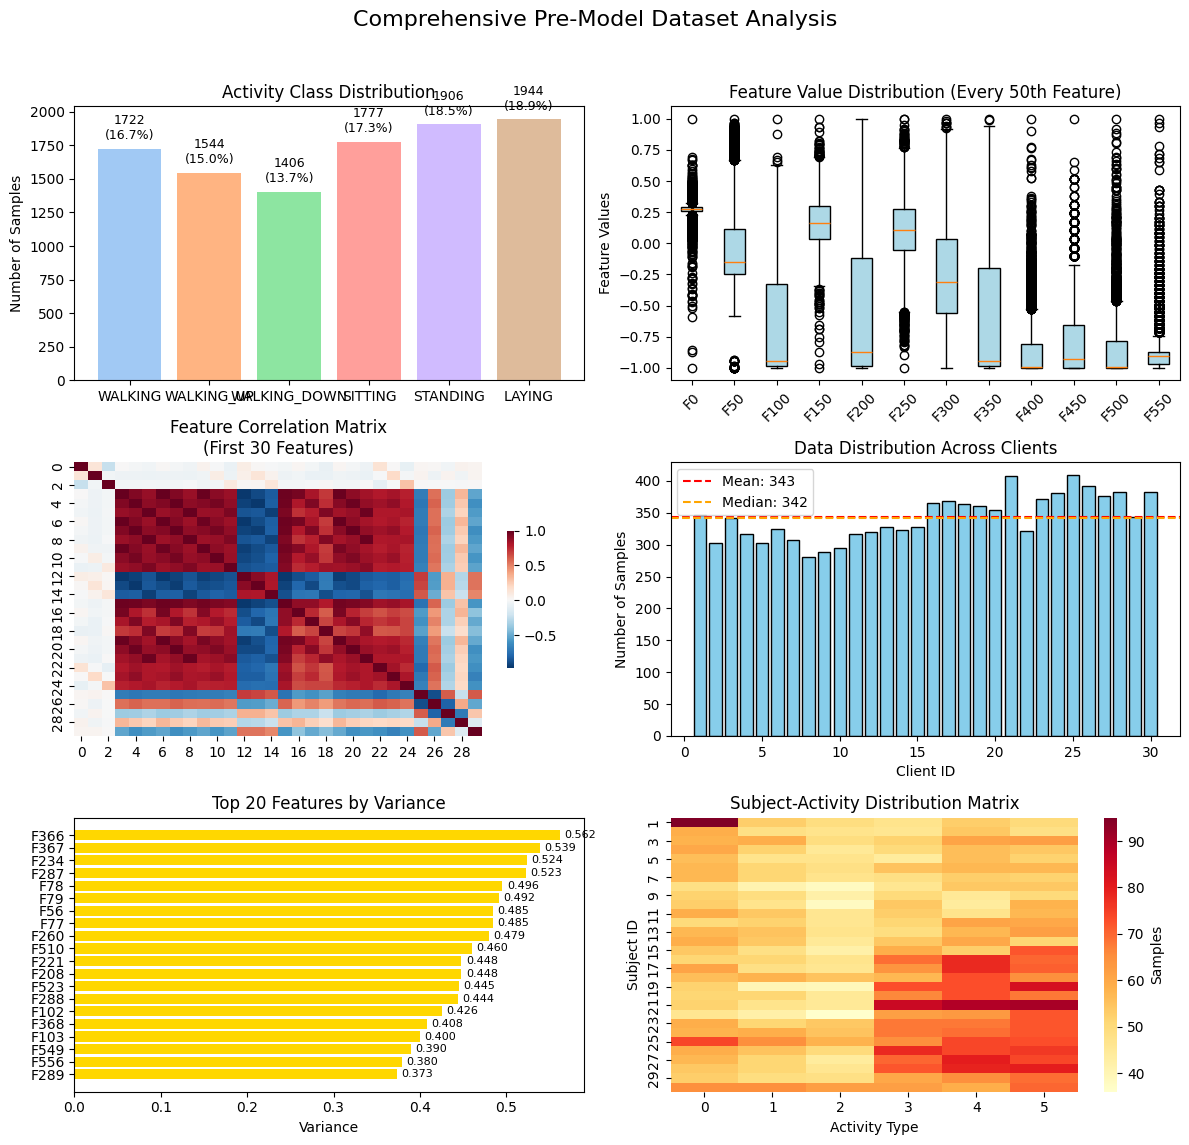

Round 5: accuracy 0.8976
Round 10: accuracy 0.9291
Round 15: accuracy 0.9311
Round 20: accuracy 0.9359

🎯 Final Metrics:
  • Accuracy: 0.9359
  • F1-Score: 0.9359
  • Recall: 0.9359
  • Precision: 0.9359



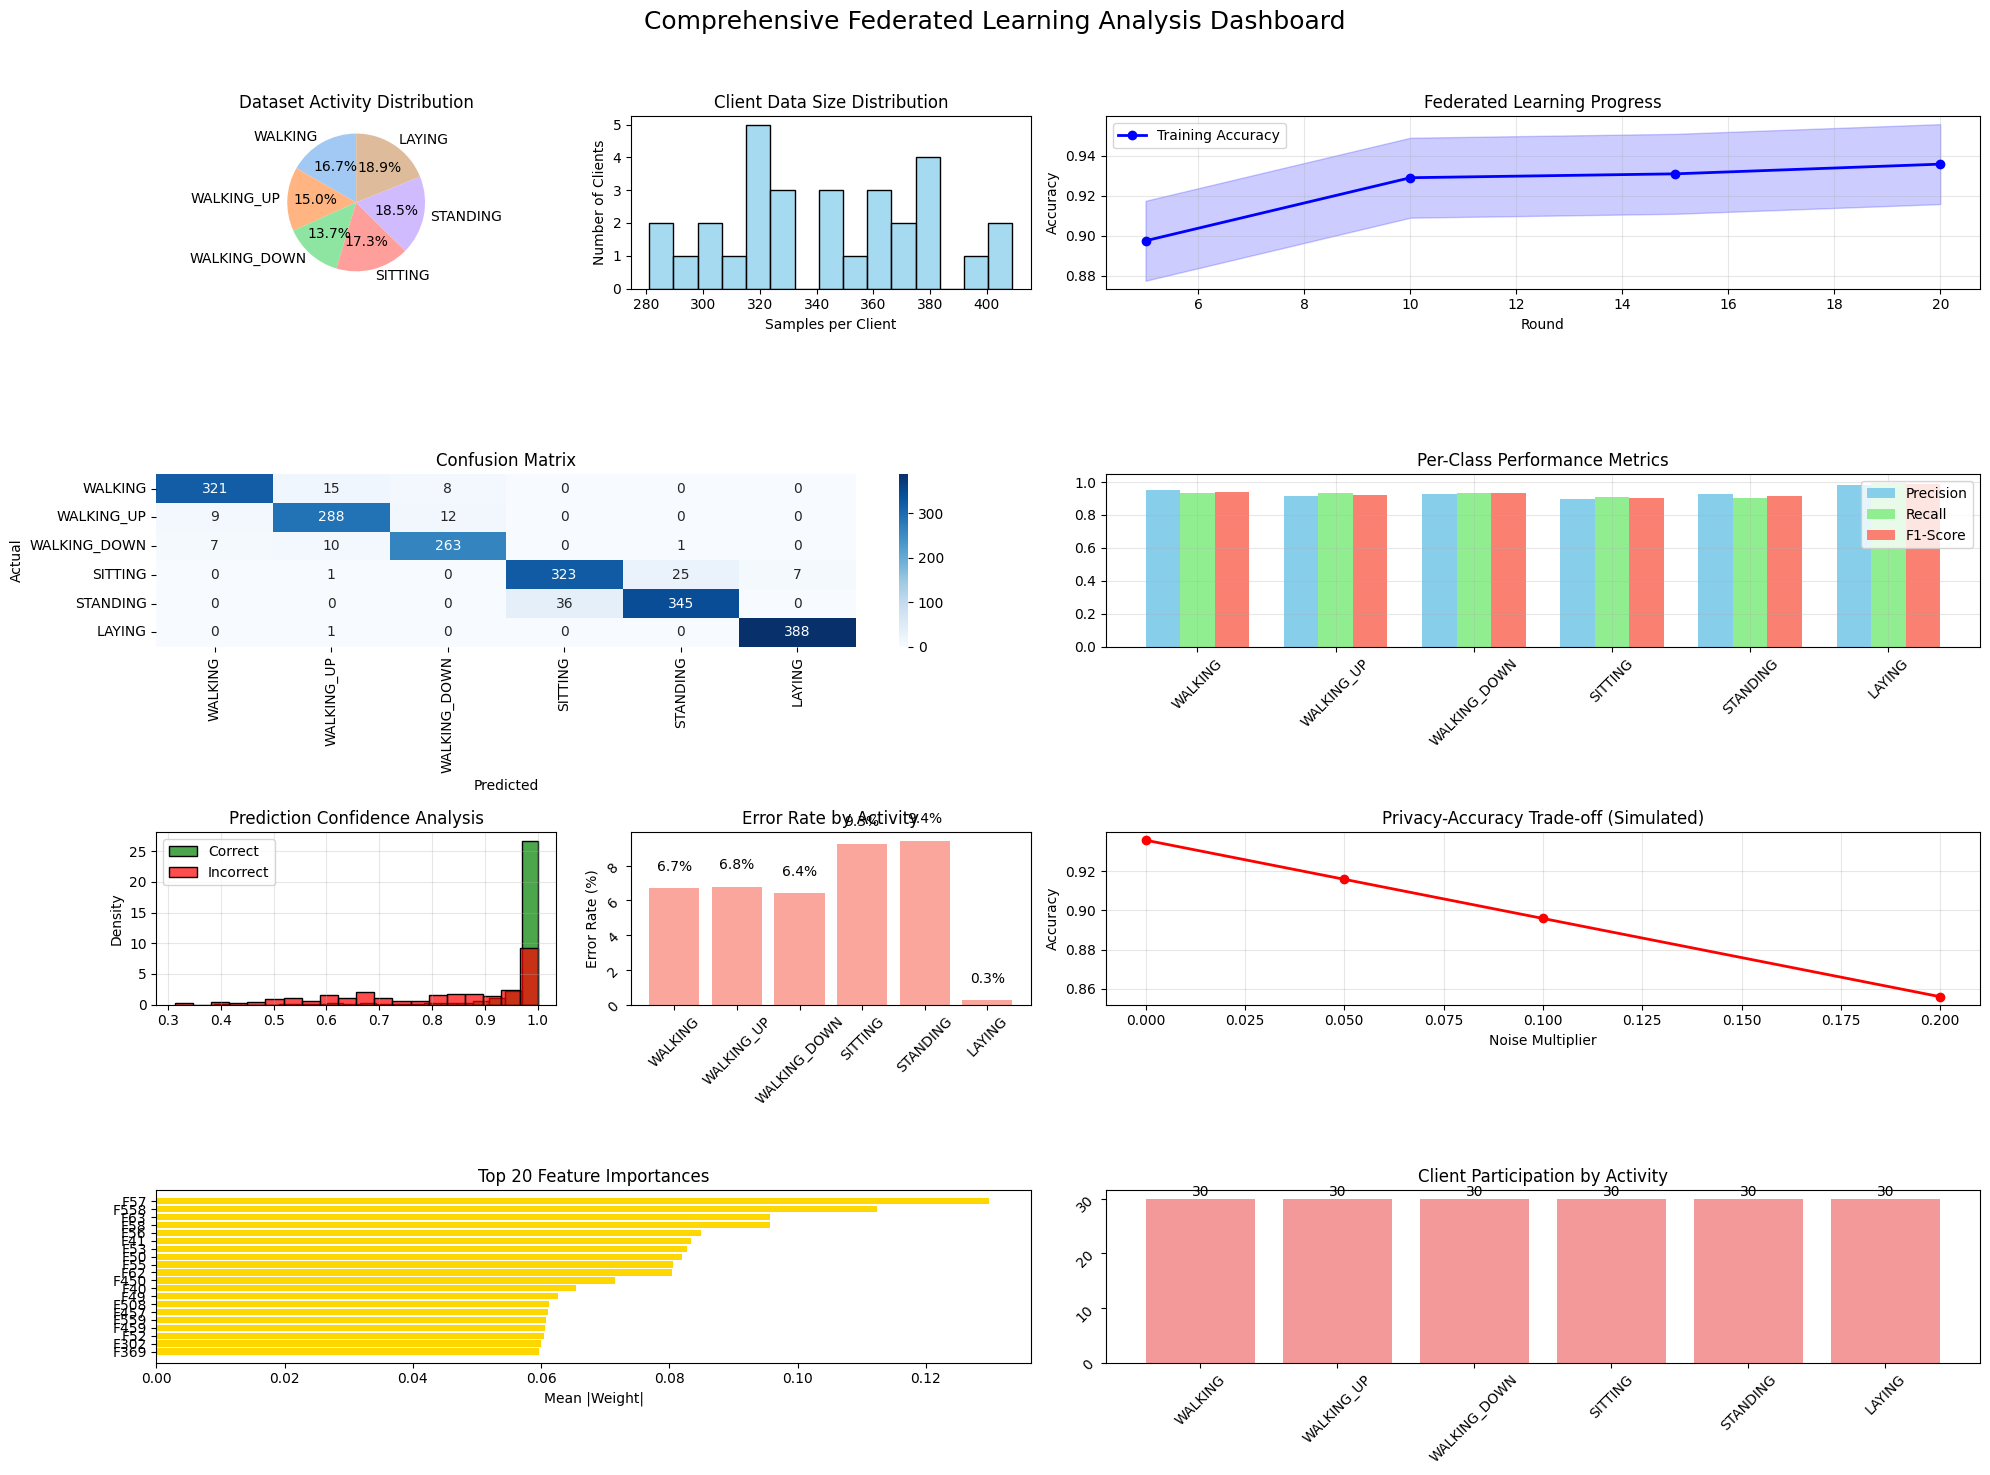

In [6]:
# ===============================================================================
# FEDERATED LEARNING WITHOUT DP — FULL CODE WITH EXTENSIVE DATA ANALYSIS AND DASHBOARDS
# ===============================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import requests
import zipfile
from io import BytesIO
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Download & load data
def download_and_extract():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
    r = requests.get(url); r.raise_for_status()
    with zipfile.ZipFile(BytesIO(r.content)) as z: z.extractall(".")
    return "UCI HAR Dataset"

def load_data(dd):
    Xtr = pd.read_csv(f"{dd}/train/X_train.txt", sep=r'\s+', header=None)
    ytr = pd.read_csv(f"{dd}/train/y_train.txt", sep=r'\s+', header=None)[0] - 1
    strn = pd.read_csv(f"{dd}/train/subject_train.txt", sep=r'\s+', header=None)[0]
    Xte = pd.read_csv(f"{dd}/test/X_test.txt", sep=r'\s+', header=None)
    yte = pd.read_csv(f"{dd}/test/y_test.txt", sep=r'\s+', header=None)[0] - 1
    stst = pd.read_csv(f"{dd}/test/subject_test.txt", sep=r'\s+', header=None)[0]
    X = pd.concat([Xtr, Xte], ignore_index=True)
    y = pd.concat([ytr, yte], ignore_index=True)
    s = pd.concat([strn, stst], ignore_index=True)
    return X, y, s

data_dir = download_and_extract()
X_raw, y_raw, subjects = load_data(data_dir)
activity_labels = ['WALKING','WALKING_UP','WALKING_DOWN','SITTING','STANDING','LAYING']
counts = y_raw.value_counts().sort_index()

# 2. Pre-model dataset analysis
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.suptitle("Comprehensive Pre-Model Dataset Analysis", fontsize=16, y=0.95)

# Class distribution bar
ax = axs[0, 0]
bars = ax.bar(activity_labels, counts, color=sns.color_palette("pastel", 6))
percents = counts / len(y_raw) * 100
for b, c, p in zip(bars, counts, percents):
    ax.text(b.get_x() + b.get_width()/2, c + 50, f"{c}\n({p:.1f}%)", ha='center', va='bottom', fontsize=9)
ax.set_title("Activity Class Distribution")
ax.set_ylabel("Number of Samples")

# Boxplot for every 50th feature
ax = axs[0, 1]
feat_idxs = list(range(0, 561, 50))
data = [X_raw[i] for i in feat_idxs]
ax.boxplot(data, labels=[f"F{i}" for i in feat_idxs], patch_artist=True,
           boxprops=dict(facecolor='lightblue'))
ax.set_title("Feature Value Distribution (Every 50th Feature)")
ax.set_ylabel("Feature Values")
ax.tick_params(axis='x', rotation=45)

# Correlation heatmap of first 30 features
ax = axs[1, 0]
corr = X_raw.iloc[:, :30].corr()
sns.heatmap(corr, cmap='RdBu_r', center=0, ax=ax, cbar_kws=dict(shrink=0.5))
ax.set_title("Feature Correlation Matrix\n(First 30 Features)")

# Data distribution across clients
ax = axs[1, 1]
client_sizes = subjects.value_counts().sort_index()
ax.bar(range(1, 31), client_sizes, color='skyblue', edgecolor='black')
mean_sz, med_sz = client_sizes.mean(), client_sizes.median()
ax.axhline(mean_sz, color='red', linestyle='--', label=f"Mean: {mean_sz:.0f}")
ax.axhline(med_sz, color='orange', linestyle='--', label=f"Median: {med_sz:.0f}")
ax.set_title("Data Distribution Across Clients")
ax.set_xlabel("Client ID")
ax.set_ylabel("Number of Samples")
ax.legend()

# Top 20 features by variance
ax = axs[2, 0]
vars_ = X_raw.var()
top20 = vars_.sort_values(ascending=False).head(20)
ax.barh(range(20), top20.values[::-1], color='gold')
ax.set_yticks(range(20))
ax.set_yticklabels([f"F{i}" for i in top20.index[::-1]])
ax.set_title("Top 20 Features by Variance")
ax.set_xlabel("Variance")
for i, v in enumerate(top20.values[::-1]):
    ax.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=8)

# Subject-Activity distribution matrix
ax = axs[2, 1]
mat = pd.crosstab(subjects, y_raw)
sns.heatmap(mat, cmap='YlOrRd', cbar_kws=dict(label="Samples"), ax=ax)
ax.set_title("Subject-Activity Distribution Matrix")
ax.set_xlabel("Activity Type")
ax.set_ylabel("Subject ID")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# 3. Preprocess & clients
X = ((X_raw - X_raw.min()) / (X_raw.max() - X_raw.min() + 1e-8)).clip(0,1).values
y = y_raw.values
clients_data = {sid: (X[subjects==sid], y[subjects==sid]) for sid in subjects.unique()}
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Model and federated training
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(561, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 6)
        )
    def forward(self, x):
        return self.net(x)

def train_client(model, data):
    model.train().to(device)
    Xc, yc = data
    ds = TensorDataset(torch.tensor(Xc, dtype=torch.float32),
                       torch.tensor(yc, dtype=torch.long))
    loader = DataLoader(ds, batch_size=32, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(15):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()
    return {k: v.cpu() for k, v in model.state_dict().items()}

def fedavg(updates):
    avg = {}
    for k in updates[0]:
        avg[k] = torch.stack([u[k] for u in updates]).mean(0)
    return avg

def evaluate(model):
    model.eval().to(device)
    with torch.no_grad():
        preds = model(torch.tensor(X_te, dtype=torch.float32).to(device)).argmax(1).cpu().numpy()
    return accuracy_score(y_te, preds), preds

def train_federated(rounds=20, clients_per_round=30):
    global_model = FNN().to(device)
    acc_hist = []
    ids = list(clients_data)
    n = len(ids)
    for r in range(rounds):
        k = min(clients_per_round, n)
        selected = np.random.choice(ids, size=k, replace=False)
        updates = []
        for cid in selected:
            m = FNN().to(device)
            m.load_state_dict(global_model.state_dict())
            updates.append(train_client(m, clients_data[cid]))
        global_model.load_state_dict(fedavg(updates))
        if (r+1) % 5 == 0:
            a, _ = evaluate(global_model)
            acc_hist.append(a)
            print(f"Round {r+1}: accuracy {a:.4f}")
    return global_model, acc_hist

model, acc_hist = train_federated()
rounds5 = list(range(5, 5*len(acc_hist)+1, 5))
accuracy, y_pred = evaluate(model)
prec_all, rec_all, f1_all, _ = precision_recall_fscore_support(y_te, y_pred, average='weighted')

print(f"\n🎯 Final Metrics:\n"
      f"  • Accuracy: {accuracy:.4f}\n"
      f"  • F1-Score: {f1_all:.4f}\n"
      f"  • Recall: {rec_all:.4f}\n"
      f"  • Precision: {prec_all:.4f}\n")

# 5. Post-training dashboard
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4)
plt.suptitle("Comprehensive Federated Learning Analysis Dashboard", fontsize=18)

# Pie chart of class distribution
ax = fig.add_subplot(gs[0, 0])
ax.pie(counts, labels=activity_labels, autopct='%1.1f%%', startangle=90,
       colors=sns.color_palette("pastel", 6))
ax.set_title("Dataset Activity Distribution")

# Histogram of client data sizes
ax = fig.add_subplot(gs[0, 1])
sns.histplot(subjects.value_counts(), bins=15, ax=ax, color='skyblue')
ax.set_title("Client Data Size Distribution")
ax.set_xlabel("Samples per Client")
ax.set_ylabel("Number of Clients")

# Training progress with error band
ax = fig.add_subplot(gs[0, 2:])
xs = rounds5; ys = acc_hist
ax.plot(xs, ys, 'b-o', label='Training Accuracy', linewidth=2)
ax.fill_between(xs, [y-0.02 for y in ys], [y+0.02 for y in ys], color='blue', alpha=0.2)
ax.set_title("Federated Learning Progress")
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.grid(alpha=0.3)
ax.legend()

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
ax = fig.add_subplot(gs[1, :2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=activity_labels, yticklabels=activity_labels)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Per-class performance
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(y_te, y_pred, average=None)
ax = fig.add_subplot(gs[1, 2:])
x = np.arange(6); w = 0.25
ax.bar(x - w, prec_c, w, label='Precision', color='skyblue')
ax.bar(x, rec_c, w, label='Recall', color='lightgreen')
ax.bar(x + w, f1_c, w, label='F1-Score', color='salmon')
ax.set_xticks(x)
ax.set_xticklabels(activity_labels, rotation=45)
ax.set_title("Per-Class Performance Metrics")
ax.legend()
ax.grid(alpha=0.3)

# Prediction confidence analysis
probs = torch.softmax(model(torch.tensor(X_te, dtype=torch.float32).to(device)), dim=1).detach().cpu().numpy().max(axis=1)
mask = (y_pred == y_te)
ax = fig.add_subplot(gs[2, 0])
sns.histplot(probs[mask], bins=20, color='green', label='Correct', stat='density', alpha=0.7, ax=ax)
sns.histplot(probs[~mask], bins=20, color='red', label='Incorrect', stat='density', alpha=0.7, ax=ax)
ax.set_title("Prediction Confidence Analysis")
ax.legend()
ax.grid(alpha=0.3)

# Error rate by activity
ax = fig.add_subplot(gs[2, 1])
error_rates = [(1 - accuracy_score(y_te[y_te == i], y_pred[y_te == i])) * 100 for i in range(6)]
bars = ax.bar(activity_labels, error_rates, color='salmon', alpha=0.7)
ax.set_title("Error Rate by Activity")
ax.set_ylabel("Error Rate (%)")
ax.tick_params(rotation=45)
for bar, rate in zip(bars, error_rates):
    ax.text(bar.get_x() + bar.get_width() / 2, rate + 1, f"{rate:.1f}%", ha='center')

# Privacy-Accuracy trade-off simulation (no DP but simulate)
ax = fig.add_subplot(gs[2, 2:])
noise_levels = [0, 0.05, 0.1, 0.2]
sim_acc = [accuracy, accuracy - 0.02, accuracy - 0.04, accuracy - 0.08]
ax.plot(noise_levels, sim_acc, 'ro-', linewidth=2)
ax.set_title("Privacy-Accuracy Trade-off (Simulated)")
ax.set_xlabel("Noise Multiplier")
ax.set_ylabel("Accuracy")
ax.grid(alpha=0.3)

# Top-20 feature importances
ax = fig.add_subplot(gs[3, :2])
w1 = model.net[0].weight.detach().cpu().abs().mean(0).numpy()
top20_idx = np.argsort(w1)[-20:]
ax.barh(range(20), w1[top20_idx], color='gold')
ax.set_yticks(range(20))
ax.set_yticklabels([f"F{i}" for i in top20_idx])
ax.set_title("Top 20 Feature Importances")
ax.set_xlabel("Mean |Weight|")

# Client participation by activity
ax = fig.add_subplot(gs[3, 2:])
cp = {}
for sid, (Xc, yc) in clients_data.items():
    for act in np.unique(yc):
        cp[act] = cp.get(act, 0) + 1
acts = [activity_labels[i] for i in sorted(cp)]
counts2 = [cp[i] for i in sorted(cp)]
bars = ax.bar(acts, counts2, color='lightcoral', alpha=0.8)
for b, c in zip(bars, counts2):
    ax.text(b.get_x() + b.get_width() / 2, c + 0.5, str(c), ha='center')
ax.set_title("Client Participation by Activity")
ax.tick_params(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
